In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from game import game

In [22]:
# Run the game 1000 times and store the results
cycles = []
for i in range(10000):
    cycles.append(game())

results = pd.DataFrame(cycles, columns=["cycles", "winner"])
results.to_csv("results.csv")
results.head(5)

,cycles,winner
0,9,B
1,23,B
2,5,A
3,11,B
4,6,A


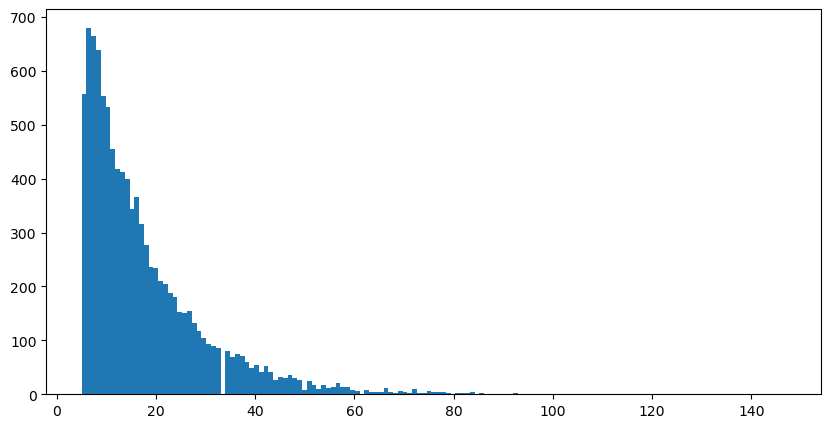

In [23]:
# Plot the number of cycles in the results as a histogram. Make the histogram wider by setting the figsize parameter.
fig, axes = plt.subplots(figsize=(10, 5))
axes.hist(results["cycles"], bins = max(results["cycles"]))
plt.show()

In [24]:
# compute the expected number of cycles
expected_cycles = results["cycles"].mean()
print("Expected number of cycles: ", expected_cycles)

Expected number of cycles:  17.5588


In [25]:
# Compute the distribution of the number of cycles
